In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import pickle
from astropy.table import Column
from astropy.table import Table
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from itertools import product
from scipy.spatial import distance_matrix
%matplotlib inline

In [3]:
N = 5             # number of stars
D = 7             # number of pixels
Q = 3             # number of labels/latent dimensions, Q<=L

In [4]:
np.random.seed(17)
X = np.random.uniform(0, 1, (N, D))          # data
Y = np.random.normal(0, 1, (N, Q))           # labels

In [5]:
# radius basis function
def kernelRBF(Z, rbf):   
    B = B_matrix(Z)
    band = 1.
    kernel = rbf * np.exp(band * B) 
    return kernel

# dimensionless log kernel
def B_matrix(Z):
    N = Z.shape[0]
    B = np.zeros((N, N))
    for entry in list(product(range(N), repeat=2)):
        i, j = entry
        B[i, j] = -0.5 * np.dot((Z[i, :] - Z[j, :]).T, (Z[i, :] - Z[j, :]))
    return B

In [6]:
# initialize parameters
theta_rbf, gamma_rbf = np.pi, np.pi
hyper_params = np.array([theta_rbf, gamma_rbf])
Z_initial = Y[:] 
Z = np.reshape(Z_initial, (N*Q,))

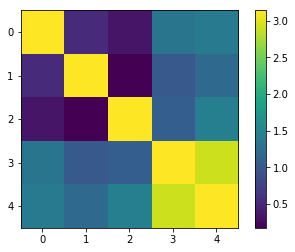

In [7]:
kernel1 = kernelRBF(Z_initial, theta_rbf)
plt.imshow(kernel1, interpolation = None)
plt.colorbar()

In [8]:
# derivative of the kernel with respect to the latent variables Z
def dKdZ(Z, rbf):
    kernel = kernelRBF(Z, rbf)
    A = A_matrix(Z)
    band = 1.
    grad_dKdZ = band * kernel[:, :, None, None] * A
    return grad_dKdZ

def A_matrix(Z): 
    N, Q = Z.shape[0], Z.shape[1]
    A = np.zeros((N, N, N, Q))
    for entry in list(product(range(N), repeat=3)):
        i, j, l = entry
        if l == j:
            A[i, j, l, :] += Z[i, :] - Z[l, :]
        if l == i:
            A[i, j, l, :] += Z[j, :] - Z[l, :]
    return A 

In [9]:
# testing the derivatives
grad_dKdZ = dKdZ(Z_initial, theta_rbf)
print grad_dKdZ.shape

(5, 5, 5, 3)


In [10]:
# derivative with respect to the 2nd latent variable of the 4th object
q = 1
l = 3
A_lq = np.zeros((N, N))
for entry in list(product(range(N), repeat=2)):
    i, j = entry
    if j == l:
        A_lq[i, j] += Z_initial[i, q] - Z_initial[l, q]
    if i == l:
        A_lq[i, j] += Z_initial[j, q] - Z_initial[l, q]
print A_lq

[[ 0.          0.          0.         -1.26455948  0.        ]
 [ 0.          0.          0.         -0.16952813  0.        ]
 [ 0.          0.          0.          0.56933462  0.        ]
 [-1.26455948 -0.16952813  0.56933462  0.         -0.00825594]
 [ 0.          0.          0.         -0.00825594  0.        ]]


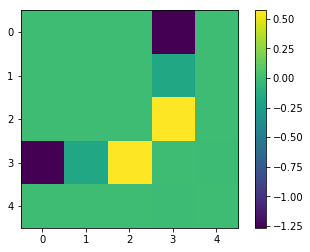

In [11]:
plt.imshow(A_lq, interpolation = None)
plt.colorbar()

# analytical derivative of the kernel

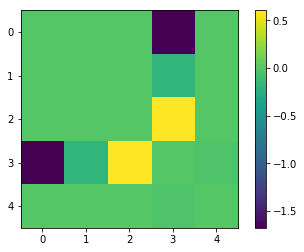

In [12]:
grad_dKdZ_analytic = kernel1 * A_lq
plt.imshow(grad_dKdZ_analytic, interpolation = None)
plt.colorbar()

# numerical derivative of the kernel

In [13]:
# sligtly new set of latent variables (2nd latent variable of 4th object)
tiny = 1e-5
Z_new = 1. * Z_initial
Z_new[l, q] += tiny
print Z_new - Z_initial

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]]


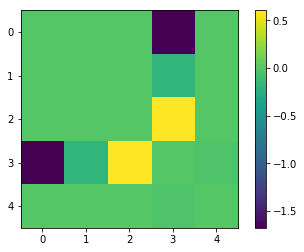

In [14]:
kernel1_new = kernelRBF(Z_new, theta_rbf)
grad_dKdZ_numerical = (kernel1_new - kernel1) / tiny
plt.imshow(grad_dKdZ_numerical, interpolation = None)
plt.colorbar()

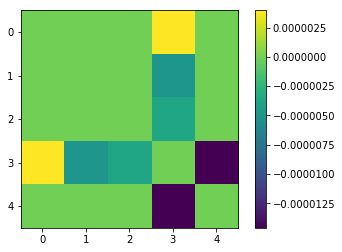

In [15]:
# difference between old and new kernel
plt.imshow(grad_dKdZ_numerical - grad_dKdZ_analytic, interpolation = None)
plt.colorbar()

# testing the derivatives of likelihood

In [74]:
def lnL_Z(pars, X, Y, hyper_params):    
    Z = np.reshape(pars, (Y.shape[0], Y.shape[1]))  
    theta_rbf, gamma_rbf = hyper_params    
    kernel1 = kernelRBF(Z, theta_rbf)
    kernel2 = kernelRBF(Z, gamma_rbf)
    
    Lx = LxOrLy(kernel1, X)                      
    Ly = LxOrLy(kernel2, Y)                          
    L = Lx + Ly + np.linalg.norm(Z)            
    
    gradL = dLdZ(X, Y, Z, kernel1, kernel2, theta_rbf, gamma_rbf)        
    gradL = np.reshape(gradL, (Y.shape[0] * Y.shape[1], ))   # reshape gradL back into 1D array   
    #print -2.*Lx, -2.*Ly 
    return -2*L, -2*gradL


def dLdK(K, data):   
    inv_K = np.linalg.inv(K)
    #grad_dLdK = 0.5 * (np.dot(inv_K, np.dot(data, np.dot(data.T, inv_K))) - data.shape[1] * inv_K)
    #grad_dLdK = 0.5 * (np.dot(inv_K, np.dot(np.dot(data, data.T), inv_K)) - data.shape[1] * inv_K)
    #grad_dLdK = 0.5 * (np.dot(np.dot(inv_K, np.dot(data, data.T)), inv_K) - data.shape[1] * inv_K)
    #grad_dLdK = 0.5 * (np.dot(np.dot(inv_K, np.dot(data, data.T)), inv_K))
    grad_dLdK = -0.5 * data.shape[1] * inv_K + 0.5 * (np.dot(np.dot(inv_K, np.dot(data, data.T)), inv_K))
    #grad_dLdK = 0.5 * ((inv_K * np.dot(data, data.T) * inv_K) - data.shape[1] * inv_K)
    return grad_dLdK                     # shape: N x N 


def dLdZ(X, Y, Z, kernel1, kernel2, theta_rbf, gamma_rbf):       
    dlnpdZ = Z / np.linalg.norm(Z)    
    grad_dKdZ1 = dKdZ(Z, theta_rbf)
    grad_dKdZ2 = dKdZ(Z, gamma_rbf)      
    grad_dLdK1 = dLdK(kernel1, X)
    grad_dLdK2 = dLdK(kernel2, Y)
    
    gradL = np.sum(grad_dLdK1[:, :, None, None] * grad_dKdZ1, axis = (0, 1)) + \
            np.sum(grad_dLdK2[:, :, None, None] * grad_dKdZ2, axis = (0, 1)) + \
            dlnpdZ    
    return gradL                         # shape: N x N x N x Q


def LxOrLy(K, data):  
    L_term1 = -0.5 * data.shape[0] * data.shape[1] * np.log(2.*np.pi)
    L_term2 = -0.5 * data.shape[1] * np.linalg.slogdet(K)[1]
    L_term3 = -0.5 * np.matrix.trace(np.dot(np.linalg.inv(K), np.dot(data, data.T)))
    #L_term3 = -0.5 * np.matrix.trace(np.linalg.inv(K) * np.dot(data, data.T))
    return L_term1 + L_term2 + L_term3


def test_lnL_Z(pars, X, Y, hyper_params):    
    qq, dldq = lnL_Z(pars, X, Y, hyper_params)   
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-5 #* pars[k]
        pars1[k] += tiny
        qq1, foo = lnL_Z(pars1, X, Y, hyper_params)
        dldqk = (qq1 - qq)/tiny
        print(k, qq, qq1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return

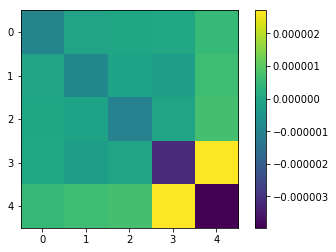

In [75]:
# test dLdK

L1 = LxOrLy(kernel1, X)
tiny = 1e-5
grad_dLdK_numerical = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        kernel1_new = 1. * kernel1
        kernel1_new[i, j] += tiny #* kernel1[i, j]
        L2 = LxOrLy(kernel1_new, X)
        grad_dLdK_numerical[i, j] = (L2 - L1) / tiny

grad_dLdK_analytic = dLdK(kernel1, X)

#print ((grad_dLdK_numerical - grad_dLdK_analytic)/(grad_dLdK_numerical + grad_dLdK_analytic))
#plt.imshow(grad_dLdK_analytic)
#plt.colorbar()

plt.imshow((grad_dLdK_numerical - grad_dLdK_analytic)/(grad_dLdK_numerical + grad_dLdK_analytic))
plt.colorbar()
#print X.shape
#inv_K = np.linalg.inv(kernel1)
#plt.imshow(np.dot(np.dot(inv_K, np.dot(X, X.T)), inv_K))
#plt.colorbar()

In [76]:
# test dLdK
kernel = kernelRBF(Z_initial, gamma_rbf)
L1 = LxOrLy(kernel, Y)
tiny = 1e-5
kernel_new = 1. * kernel
kernel_new[0, 0] += tiny
L2 = LxOrLy(kernel_new, Y)

inv_K = np.linalg.inv(kernel)
grad_dLdK = -0.5 * Y.shape[1] * inv_K + 0.5 * (np.dot(np.dot(inv_K, np.dot(Y, Y.T)), inv_K))
det_K = np.linalg.det(kernel)
print grad_dLdK[0,0] - (L2-L1)/tiny
print (grad_dLdK[0,0] - (L2-L1)/tiny)/(grad_dLdK[0,0] + (L2-L1)/tiny)

-8.57688972511e-07
8.31998552032e-07


In [79]:
# test dlnpdZ 
l, q = 0, 0 
L1 = np.linalg.norm(Z_initial)
tiny = 1e-3
Z_new = 1. * Z_initial
Z_new[l, q] += tiny
L2 = np.linalg.norm(Z_new)

dlnpdZ = Z_initial / np.linalg.norm(Z_initial)
print (L2-L1)/tiny - dlnpdZ[l, q]

0.000203272713898


In [80]:
# test dLdZ
test_lnL_Z(Z, X, Y, hyper_params)

(0, 123.51083301372368, 123.51083750811392, 0.44943902395289109, 0.4494245219655485, -1.6133691713772692e-05)
(1, 123.51083301372368, 123.51077947082096, -5.3542902719527774, -5.354221225773002, -6.4477849970182595e-06)
(2, 123.51083301372368, 123.51083080437296, -0.22093507254794528, -0.22094083963535716, 1.305137314088486e-05)
(3, 123.51083301372368, 123.51078778302607, -4.5230697608644732, -4.5230094801230898, -6.6637423548416648e-06)
(4, 123.51083301372368, 123.51082545144961, -0.75622740780545417, -0.75623831517320106, 7.2116462417488238e-06)
(5, 123.51083301372368, 123.51083573405798, 0.27203342938264541, 0.27202332423726738, -1.8573697157126096e-05)
(6, 123.51083301372368, 123.51088894958255, 5.5935858867428569, 5.5936254797606217, 3.5391320023989783e-06)
(7, 123.51083301372368, 123.51086506103563, 3.2047311947280828, 3.2047238398292111, -1.1475076792113362e-06)
(8, 123.51083301372368, 123.51085688912984, 2.3875406157003454, 2.3875249849110811, -3.2734187488968335e-06)
(9, 123.5

# testing different summing algorithms...

In [20]:
# CAVEAT: differences of order 1e-17 for different sums!!

grad_dKdZ1 = dKdZ(Z_initial, theta_rbf)
grad_dKdZ2 = dKdZ(Z_initial, gamma_rbf)

kernel1 = kernelRBF(Z_initial, theta_rbf)
kernel2 = kernelRBF(Z_initial, gamma_rbf)

grad_dLdK1 = dLdK(kernel1, X)
grad_dLdK2 = dLdK(kernel2, Y)

print grad_dKdZ1.shape, grad_dKdZ2.shape, grad_dLdK1.shape, grad_dLdK2.shape

xx = np.sum(np.sum(grad_dLdK2[:, :, None, None] * grad_dKdZ2, axis = 0), axis = 0)

vv = np.sum(np.sum(grad_dLdK2[:, :, None, None] * grad_dKdZ2, axis = 1), axis = 0)

zz = np.sum(grad_dLdK2[:, :, None, None] * grad_dKdZ2, axis = (0, 1))

yy = np.zeros((N, Q))
for l in range(N):
    for q in range(Q):
        yy[l, q] = np.sum(grad_dLdK2 * grad_dKdZ2[:, :, l, q], axis = (0, 1))
        
print vv - zz 
print xx - yy

(5, 5, 5, 3) (5, 5, 5, 3) (5, 5) (5, 5)
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.77555756e-17   0.00000000e+00]
 [ -5.55111512e-17   0.00000000e+00   0.00000000e+00]]
[[  0.00000000e+00   0.00000000e+00  -6.50521303e-19]
 [  0.00000000e+00   0.00000000e+00  -1.38777878e-17]
 [  0.00000000e+00   0.00000000e+00   1.04083409e-17]
 [ -2.77555756e-17   2.77555756e-17   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -1.11022302e-16]]


# testing derivatives of hyper parameters

In [94]:
def lnL_h(pars, X, Y, Z, Z_initial):
    
    Z = np.reshape(Z, (Y.shape[0], Y.shape[1]))      
    theta_rbf, gamma_rbf = pars    
    kernel1 = kernelRBF(Z, theta_rbf)
    kernel2 = kernelRBF(Z, gamma_rbf)
    
    Lx = LxOrLy(kernel1, X)                      
    Ly = LxOrLy(kernel2, Y)                        
    L = Lx + Ly #+ np.linalg.norm(Z_initial)
    
    gradL = dLdhyper(X, Y, Z, pars, kernel1, kernel2) 
    print -2.*Lx, -2.*Ly 
    return -2.*L, -2.*gradL


def test_likelihood_h(pars, X, Y, Z, Z_initial):
    
    q, dldq = lnL_h(pars, X, Y, Z, Z_initial)
    
    for k in range(len(pars)):
        pars1 = 1. * pars
        tiny = 1e-5 #* pars[k]
        pars1[k] += tiny
        q1, foo = lnL_h(pars1, X, Y, Z, Z_initial)
        dldqk = (q1 - q)/tiny
        print(k, q, q1, dldqk, dldq[k], (dldq[k]-dldqk)/(dldq[k]+dldqk))
    return


def dLdhyper(X, Y, Z, hyper_params, kernel1, kernel2):  
    theta_rbf, gamma_rbf = hyper_params     
    dKdrbf1 = 1./theta_rbf * kernel1
    dKdrbf2 = 1./gamma_rbf * kernel2
    
    dLdtheta_rbf = np.sum(dLdK(kernel1, X) * dKdrbf1)    
    dLdgamma_rbf = np.sum(dLdK(kernel2, Y) * dKdrbf2)   
    return np.array([dLdtheta_rbf, dLdgamma_rbf])

In [95]:
# initialize parameters
theta_rbf, gamma_rbf = np.pi, np.pi
hyper_params = np.array([theta_rbf, gamma_rbf])
Z_initial = Y[:] 
Z = np.reshape(Z_initial, (N*Q,))

In [96]:
test_likelihood_h(hyper_params, X, Y, Z, Z_initial)

89.6355489649 38.5973172015
89.6356461158 38.5973172015
(0, 128.23286616644123, 128.23296331730023, 9.7150859005523671, 9.7150990946500357, 6.7905157217509332e-07)
89.6355489649 38.597358258
(1, 128.23286616644123, 128.2329072229407, 4.105649946950507, 4.1056554190305352, 6.6640805381360583e-07)


In [101]:
gradL = dLdhyper(X, Y, Z, hyper_params, kernel1, kernel2)
L1 = LxOrLy(kernel1, X)
tiny = 1e-5
kernel_new = kernelRBF(Z_initial, theta_rbf + tiny)
L2 = LxOrLy(kernel_new, X)
print (L2-L1)/tiny - gradL[0]

6.59704883432e-06
